# Identificación de infecciones fúngicas clínicas mediante espectroscopía Raman unicelular y aprendizaje profundo

### Introducción
El diagnóstico de infecciones fúngicas es lento y poco preciso con métodos tradicionales. Aunque la espectroscopía Raman permite una identificación rápida, los modelos actuales requieren varios espectros por paciente y votación para clasificar bien [1][2].

Se usó una base de datos de espectros Raman que contiene 94 aislamientos clínicos de hongos, uno por cada paciente, y para cada aislamiento se midieron más de 1,000 espectros Raman de célula única. En total, la base de datos incluye 115,129 espectros. Las muestras fueron recolectadas a partir de diversos fluidos corporales, como orina, sangre, líquido cefalorraquídeo, ascitis, lavados y derrames pleurales [1].

A continuación, se plantea un enfoque de clasificación basado en redes neuronales convolucionales 1D (CNN 1D), que permite identificar la especie fúngica directamente a partir de un único espectro Raman. Este enfoque busca eliminar la necesidad de agregación por votación, mejorando la eficiencia diagnóstica sin comprometer la precisión.

### Metodología

1. Se cargó la base de datos desde *fungi_spectra.csv* que contiene espectros Raman unicelulares.

2. Los espectros fueron normalizados por su valor máximo.

3. Los datos se dividieron en entrenamiento (80%), validación (10%) y prueba (10%) estratificados por especie.

4. Se utilizó una arquitectura CNN 1D con capas convolucionales, batch normalization, LeakyReLU y pooling para extraer características de los espectros.

5. La salida de las capas convolucionales se proyectó en un espacio de embedding con capas completamente conectadas y se normalizó.

6. Finalmente, una capa lineal clasificó los espectros en sus respectivas especies.

### Resultados
El modelo CNN 1D logró una precisión del 98.43% en el conjunto de prueba. La matriz de confusión muestra que la mayoría de las especies se identificaron correctamente, con mínimas confusiones principalmente entre *Candida albicans* y *Candida tropicalis*. *Cryptococcus neoformans* fue perfectamente clasificada. 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# `load_fungal_dataset`: Función que lee y prepara los datos para el entrenamiento.
def load_fungal_dataset(path, seed=42):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()

    X = df.drop(columns=["Sample", "Instru", "Strain", "Species", "Genus"], errors='ignore').values.astype(np.float32)
    y = df['Species'].values

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X = X / (np.max(X, axis=1, keepdims=True) + 1e-8)

    # 80% train, 10% val, 10% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.20, random_state=seed, stratify=y_encoded)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=seed, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test, le

In [ ]:
# Capas convolucionales para capturar patrones locales y específicos en los datos espectrales.
# Capas completamente conectadas para sintetizar las características extraídas en un espacio compacto.
# Normalización del embedding para tener una representación más robusta.
# Clasificador final para una decisión directa y eficiente sobre las clases de especies.

class RamanNetCNN1D(nn.Module):
    def __init__(self, input_length, embedding_dim, n_classes):
        super(RamanNetCNN1D, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        conv_output_dim = (input_length // 4) * 64

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(conv_output_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, embedding_dim)
        )

        self.embedding_norm = nn.functional.normalize

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(embedding_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(embedding_dim, n_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)
        embedding = self.fc_layers(x)
        embedding = self.embedding_norm(embedding, dim=1)

        classification = self.classifier(embedding)

        return embedding, classification


In [6]:
path = r"D:\1. Ingeniería Biomédica\12 CICLO\Reconocimiento de Patrones\ramannet_fungi_project\data\fungi_spectra.csv"
embedding_dim = 256
batch_size = 128
epochs = 20
seed = 13

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test, le = load_fungal_dataset(path, seed=seed)
input_length = X_train.shape[1]
n_classes = len(np.unique(y_train))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# La optimización se realizó usando Adam, y la función de pérdida usada fue la cross-entropy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RamanNetCNN1D(input_length=input_length, embedding_dim=embedding_dim, n_classes=n_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss()

In [10]:
for epoch in range(epochs):
    model.train()
    total_loss, all_preds, all_labels = 0.0, [], []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        _, class_preds = model(X_batch)
        loss = ce_loss(class_preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(class_preds.argmax(dim=1).cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f} | Train Acc: {acc:.4f}")

Epoch 1 - Loss: 0.3211 | Train Acc: 0.8847
Epoch 2 - Loss: 0.1893 | Train Acc: 0.9319
Epoch 3 - Loss: 0.1562 | Train Acc: 0.9426
Epoch 4 - Loss: 0.1354 | Train Acc: 0.9513
Epoch 5 - Loss: 0.1267 | Train Acc: 0.9546
Epoch 6 - Loss: 0.1137 | Train Acc: 0.9588
Epoch 7 - Loss: 0.1076 | Train Acc: 0.9610
Epoch 8 - Loss: 0.0989 | Train Acc: 0.9647
Epoch 9 - Loss: 0.0952 | Train Acc: 0.9654
Epoch 10 - Loss: 0.0874 | Train Acc: 0.9678
Epoch 11 - Loss: 0.0837 | Train Acc: 0.9698
Epoch 12 - Loss: 0.0773 | Train Acc: 0.9717
Epoch 13 - Loss: 0.0753 | Train Acc: 0.9721
Epoch 14 - Loss: 0.0720 | Train Acc: 0.9741
Epoch 15 - Loss: 0.0683 | Train Acc: 0.9752
Epoch 16 - Loss: 0.0668 | Train Acc: 0.9758
Epoch 17 - Loss: 0.0650 | Train Acc: 0.9765
Epoch 18 - Loss: 0.0619 | Train Acc: 0.9769
Epoch 19 - Loss: 0.0607 | Train Acc: 0.9783
Epoch 20 - Loss: 0.0573 | Train Acc: 0.9795


In [11]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        _, class_preds = model(X_batch)
        all_preds.extend(class_preds.argmax(dim=1).cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9843


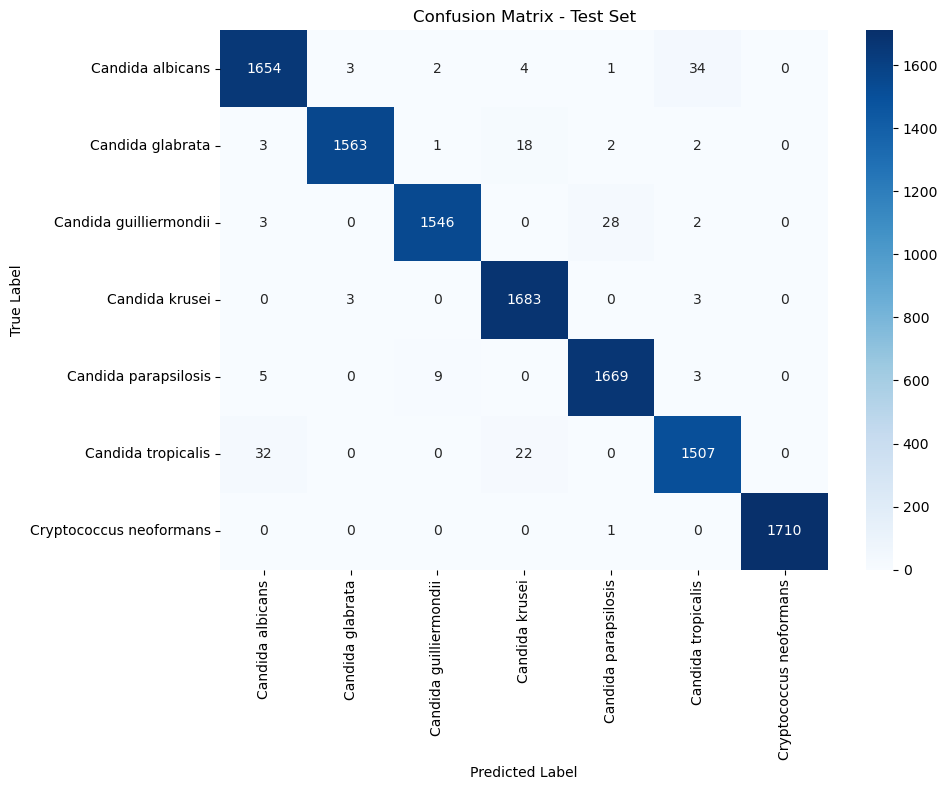

In [12]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

In [13]:
# El modelo entrenado se guardó en disco para su uso posterior
torch.save(model.state_dict(), "ramannet_weights.pth")

### Referencias
 [1] J. Xu, Y. Luo, J. Wang, W. Tu, X. Yi, X. Xu, Y. Song, Y. Tang, X. Hua, Y. Yu, H. Yin, Q. Yang, and W. E. Huang, “Artificial intelligence-aided rapid and accurate identification of clinical fungal infections by single-cell Raman spectroscopy,” Frontiers in Microbiology, vol. 14, Mar. 2023. [Online]. Available: https://doi.org/10.3389/fmicb.2023.1125676

 [2] C. S. Ho, N. Jean, C. A. Hogan, et al., “Rapid identification of pathogenic bacteria using Raman spectroscopy and deep learning,” Nature Communications, vol. 10, p. 4927, Oct. 2019. [Online]. Available: https://doi.org/10.1038/s41467-019-12898-9